$$ \Huge \text{Binary Classifiers}$$
$$ \Huge \text{Classification Problems} $$
$$ Binh ~ Tran $$

# Gender problem based on face image

## Import libraries

In [1]:
# import Libraries
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

## Config

In [2]:
# config
data_folder = 'data'

## Show test data

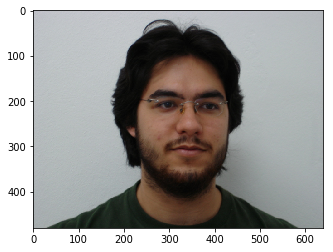

In [4]:
# Show test data
def show_image(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
show_image(data_folder+'/13-06.jpg')

## Feature engineering 

### Get face: 
___
* Face detection
* Get face region
* Resize face
* Save face to drop folder

In [5]:
import os

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:

for file in os.listdir(data_folder):
    if not file.endswith(".jpg"):
        continue
    image_path = "%s/%s" % (data_folder,file)
    print(image_path)
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        print("\tProcess drop face ...")
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        print("\t Write new file...%s/drop/%s" % (data_folder, file) )
        resized_image = cv2.resize(roi_color, (100, 100))
        cv2.imwrite('%s/drop/%s' % (data_folder, file) ,resized_image)
#         just get the first face
        break        

### Show sample drop image

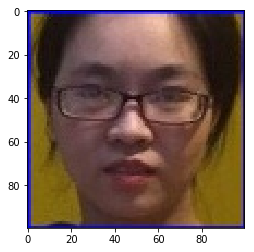

In [6]:
show_image('%s/drop/3.0-image.jpg'%data_folder)

### Label images

This step we manual label droped image by name convension and store it in folder **face_with_label**

File name in format with subfix: **-M** for **Male** and **-F** for **Femal **

In [ ]:
show_image('%s/face_with_label/3.0-image-F.jpg'%data_folder)

## Import ML Libraries

In [7]:
import numpy as np 
from sklearn import linear_model           # for logistic regression
from sklearn.metrics import accuracy_score # for evaluation
import imageio
import os
import pandas as pd
np.random.seed(1)      

## Define Project matrix to reduce demension

In [8]:
D = 100*100 # original dimension 
d = 500 # new dimension 

# generate the projection matrix 
ProjectionMatrix = np.random.randn(D, d) 

## Convert color image to gray

In [9]:
## Convert color image to gray
def rgb2gray(rgb):
#     Y' = 0.299 R + 0.587 G + 0.114 B 
    return rgb[:,:,0]*.299 + rgb[:, :, 1]*.587 + rgb[:, :, 2]*.114

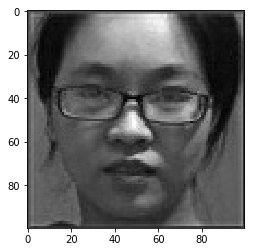

In [10]:
img = cv2.imread('%s/face_with_label/3.0-image-F.jpg'%data_folder)

# gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image = rgb2gray(img)

plt.imshow(gray_image, cmap="gray")
plt.show()

## Feature extraction 
    Vectorize images

In [12]:
# feature extraction 
def vectorize_img_from_file(filename):    
    # load image 
    rgb = imageio.imread(filename)
    return vectorize_img(rgb)

def vectorize_img(img): 
    # convert to gray scale 
    gray = rgb2gray(img)
    # vectorization each row is a data point 
    im_vec = gray.reshape(1, D)
    return im_vec 

## Build data matrix

In [13]:
def build_data_matrix(path):
   
    files = os.listdir(path)

    files = [f for f in files if f.endswith(".jpg") ] 

    total_imgs = len(files)
    X_full = np.zeros((total_imgs, D))
    y = []

    for i in range(total_imgs):
        file = files[i]
        if file.endswith(".jpg"):
#             print('Processing image: %s' %file)
            file_name_full = path + file
            f = file.split(".jpg")
            label = 1
            if (f[0][-1] == 'F'):
                label = 0
            X_full[i, :] = vectorize_img_from_file(file_name_full)
            y.append(label)

    X = np.dot(X_full, ProjectionMatrix)
    return (X, y)

(X_full, y_full) = build_data_matrix('%s/face_with_label/' % data_folder)
x_mean = X_full.mean(axis = 0)
x_var  = X_full.var(axis = 0)

In [14]:
import pandas as pd
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display(HTML(html_str.replace('table','table style="display:inline"')))

In [15]:
pd_X = pd.DataFrame(X_full).head()
pd_y = pd.DataFrame(y_full, columns=['Label']).head()
pd_mean = pd.DataFrame(x_mean, columns=['mean']).head()
pd_var = pd.DataFrame(x_var, columns=['var']).head()
display_side_by_side(pd_X, pd_y, pd_mean, pd_var)

## Feature Scaling and Normalization

In [16]:
def feature_extraction(X):
    return (X - x_mean)/x_var
X_full_extraction = feature_extraction(X_full)
X_full = None ## free this variable

In [18]:
pd.DataFrame(X_full_extraction)

0         1         2         3         4         5         6    \
0    0.000265 -0.000383  0.000116  0.000187 -0.000256 -0.000160  0.000219   
1    0.000350 -0.000180  0.000142  0.000146 -0.000272 -0.000205  0.000214   
2   -0.000182  0.000250 -0.000463 -0.000376  0.000084  0.000209 -0.000286   
3    0.000004  0.000357  0.000144  0.000025 -0.000161 -0.000044  0.000145   
4   -0.000005  0.000511  0.000176 -0.000303 -0.000127 -0.000031 -0.000026   
5    0.000142  0.000132 -0.000072 -0.000337  0.000163 -0.000021 -0.000173   
6   -0.000164  0.000077 -0.000161 -0.000160  0.000284  0.000075 -0.000241   
7   -0.000047  0.000274  0.000053 -0.000014 -0.000281  0.000033 -0.000022   
8    0.000019  0.000172  0.000116  0.000167 -0.000142  0.000012  0.000028   
9   -0.000155  0.000228 -0.000162 -0.000390  0.000053  0.000106 -0.000119   
10  -0.000115  0.000009 -0.000389 -0.000104  0.000251  0.000101 -0.000165   
11  -0.000056  0.000102  0.000105  0.000087  0.000048 -0.000009  0.000137   
12  -0.000278  0.000256 -0.000198 -0.000142  0.000082  0.000041 -0.000093   
13  -0.000121  0.000119  0.000101  0.000142  0.000003  0.000071  0.000018   
14  -0.000113  0.000238 -0.000086  0.000060 -0.000059  0.000093  0.000009   
15   0.000190 -0.000090  0.000152  0.000229 -0.000268 -0.000086  0.000209   
16  -0.000096  0.000678  0.000068 -0.000167  0.000019  0.000055 -0.000033   
17  -0.000066 -0.000676  0.000032 -0.000128  0.000047  0.000018  0.000064   
18  -0.000280 -0.000139 -0.000202 -0.000186  0.000219  0.000275 -0.000156   
19   0.000113 -0.000221 -0.000008  0.000075  0.000094 -0.000239 -0.000121   
20  -0.000161 -0.000503 -0.000251 -0.000387  0.000315  0.000147  0.000004   
21   0.000186 -0.000423  0.000106  0.000122  0.000166 -0.000047  0.000073   
22  -0.000088 -0.000115 -0.000072  0.000061  0.000060  0.000062  0.000030   
23   0.000080 -0.000432 -0.000113 -0.000284  0.000138  0.000111  0.000001   
24  -0.000078  0.000481  0.000019 -0.000033 -0.000225  0.000086  0.000067   
25  -0.000281  0.000246 -0.000193 -0.000320  0.000226  0.000088 -0.000151   
26  -0.000243  0.000191  0.000011 -0.000179  0.000079  0.000116 -0.000053   
27   0.000086 -0.000146 -0.000064  0.000033  0.000047  0.000046 -0.000073   
28   0.000009  0.000296  0.000054 -0.000448  0.000467  0.000092 -0.000188   
29  -0.000096  0.000115  0.000050 -0.000107  0.000028  0.000003  0.000090   
..        ...       ...       ...       ...       ...       ...       ...   
379  0.000201  0.000254  0.000163  0.000050 -0.000278 -0.000264  0.000250   
380 -0.000232  0.000172 -0.000213  0.000307  0.000182  0.000078 -0.000083   
381  0.000071  0.000166 -0.000186 -0.000003  0.000188  0.000179 -0.000050   
382  0.000236 -0.000054  0.000179  0.000129 -0.000144 -0.000135  0.000112   
383  0.000196 -0.000104  0.000131  0.000185 -0.000178 -0.000126  0.000132   
384  0.000003  0.000027 -0.000072 -0.000243 -0.000199  0.000029 -0.000030   
385 -0.000225 -0.000080 -0.000091 -0.000183 -0.000011  0.000005 -0.000141   
386  0.000066 -0.000191 -0.000096  0.000252  0.000319  0.000050 -0.000095   
387  0.000009 -0.000145  0.000009 -0.000016  0.000233  0.000200 -0.000193   
388 -0.000314 -0.000113 -0.000236 -0.000366  0.000057  0.000161 -0.000174   
389 -0.000225 -0.000102 -0.000156 -0.000104  0.000191  0.000207 -0.000022   
390 -0.000157 -0.000199 -0.000044  0.000169 -0.000050  0.000094  0.000100   
391  0.000033 -0.000533 -0.000034 -0.000076 -0.000100 -0.000053  0.000122   
392 -0.000298  0.000024 -0.000047  0.000079  0.000153  0.000085 -0.000062   
393  0.000132  0.000582  0.000359 -0.000213 -0.000209  0.000094  0.000044   
394 -0.000078  0.000391 -0.000019 -0.000294  0.000085  0.000065 -0.000211   
395 -0.000223 -0.000518 -0.000111 -0.000293 -0.000297  0.000178 -0.000021   
396 -0.000065 -0.000194 -0.000105 -0.000163  0.000102  0.000032 -0.000254   
397 -0.000272 -0.000155 -0.000271 -0.000293  0.000329  0.000220  0.000023   
398  0.000105 -0.000223 -0.000110 -0.000209  0.000392 -0.000016 -0.000303   
399 -0

## Split data for traning & test data

In [19]:
training_number = 160
X_train = X_full_extraction[:training_number]
y_train = y_full[:training_number]
X_test = X_full_extraction[training_number:]
y_test = y_full[training_number:]

In [20]:
logreg = linear_model.LogisticRegression(C=1e5) # just a big number
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print ("Accuracy: %.2f %%" %(100*accuracy_score(y_test, y_pred)))

Accuracy: 65.06 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Binary Classifiers for Multi-class Classification problems

if there are more than two classes, such as 10 MNIST classes, how?

## One-vs-one

Build lots of binary classifiers for each pair of classes

Thus, if there are C classes then the total number of binary classifiers must be used

$$ \frac {C(C − 1)} {2}$$

Too large $\Rightarrow$ this method is not beneficial in terms of calculations

If a digit is 1 but input it in the classifier between 5 and 6 $\Rightarrow$ predict will be 5 or 6.


## Hierarchical

As we see the numbers 4 and 7 are quite similar, the numbers 5 and 6 are quite similar, so we
* First construct the classifier [4, 7] vs. [5, 6].
* Then build two classifiers of 4 vs 7 and 5 vs 6.

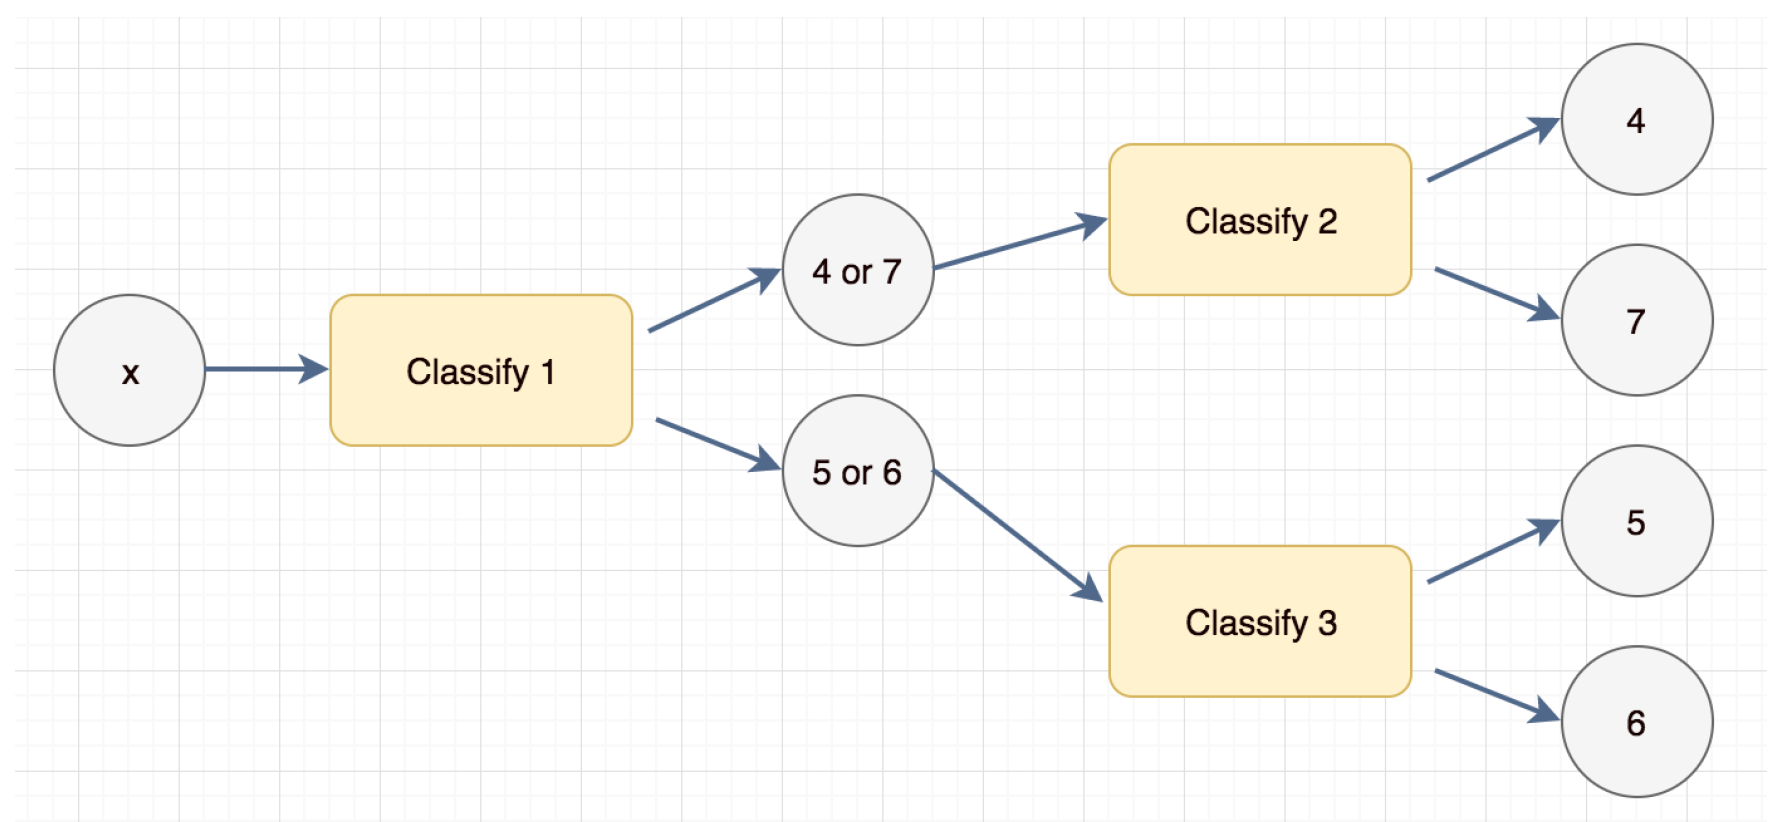

In total, we need 3 sets of binary classifiers.

* The advantage of this approach is that it uses fewer binary classifiers than one-vs-one.
* Its disadvantage is that if only one binary classifier yields the wrong result then the end result would
be wrong.

## Binary coding

Encode the output of each class by a binary number

* For example, if there are 4 classes, the four class are 00, 01, 10, and 11.
* The number of binary classifiers is just m = log2 (C) where C is the number of classes

* Advantage: This approach uses the smallest number of binary classifiers.
* Disadvantage
Very big limitation that just one bit of misclassification will lead to misclassified data.
If the number of classes must be the **exponent of two**

## one-vs-rest and one-hot coding

* List of names:
    * one-vs-rest
    * ove-vs-all
    * one-against-rest
    * one-against-all

If there are **n** classes, we will build __n__ classifiers, each of which corresponds to a class

The first classifier distinguishes class 1 vs not class 1. This means that whether or not a point is in class 1, or
the probability of a point falls into class 1.

## one-hot coding

This method is also known as one-hot coding, because with the above encoding, suppose that there are
four classes, class 1, 2, 3, 4, which are encoded in turn. binary by 

$\mathbf1000, 0\mathbf100, 00\mathbf10, 000\mathbf1$

One-hot because only one bit is hot (equal to 1).

## Limitations of one-vs-rest

* A data point can be predicted to belong to class 1,2, ..., C with the probability p1, p2, ..., pC
respectively.
* However, the sum of these probabilities may not be 1!
* There is a method (Softmax Regression) that can make the sum of these probabilities by 1. Then,
with one data point we can say how probability it is to fall into each class

## In the form of Neural Networks